## 設定

In [33]:
# xgboostについてはpathを設定する必要がある
import sys
# sys.path.append('/Users/takuto/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')
# sys.path.append('/Users/takuto/.pyenv/versions/3.6.5/lib/python3.6/site-packages')

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import feather
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
import time
from sklearn import preprocessing
import warnings
import datetime
warnings.filterwarnings("ignore")
import gc
from tqdm import tqdm

from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
### 2つを同時に入れた方が良いのかも?? ###
import xgboost as xgb
import lightgbm as lgb

## 基礎集計

In [34]:
# この関数何? おそらく情報圧縮しているっぽい?
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [27]:
import os
print(os.listdir("../input/feather/"))

['historical_transactions.feather', 'new_merchant_transactions.feather', 'merchants.feather', 'test.feather', 'train.feather', 'sample_submission.feather']


In [30]:
#Loading Train and Test Data
train = feather.read_dataframe("../input/feather/train.feather")
test = feather.read_dataframe("../input/feather/test.feather")
print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))

201917 observations and 6 features in train set.
123623 observations and 5 features in test set.


In [31]:
# target value
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

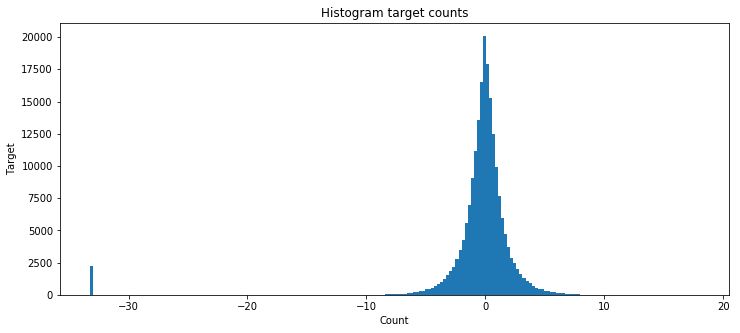

In [35]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

## Feature engineering

In [36]:
# pandas datetime
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
# 時間差
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
# 外れ値情報を含める
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
# targetを別データに移動
target = train['target']
del train['target']

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,outliers
0,2017-06-01,C_ID_92a2005557,5,2,1,245,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,0


In [46]:
# 取引情報データ
new_transactions = feather.read_dataframe('../input/feather/new_merchant_transactions.feather')
historical_transactions =feather.read_dataframe('../input/feather/historical_transactions.feather')
# Label encoding
# category_encodersという便利なものあるらしい
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [47]:
historical_transactions.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07+00:00,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45+00:00,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29+00:00,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26+00:00,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19+00:00,1.0,16,37
5,1,C_ID_4e6213e9bc,333,0,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05+00:00,1.0,9,37
6,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51+00:00,1.0,16,37
7,1,C_ID_4e6213e9bc,3,0,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55+00:00,1.0,16,37
8,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56+00:00,1.0,16,37
9,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22+00:00,1.0,16,37


In [48]:
# one hot encoding
import category_encoders as ce
# Eoncodeしたい列をリストで指定
list_cols = ['category_2', 'category_3']
# OneHotEncodeしたい列を指定。Nullや不明の場合の補完方法も指定。
ce_ohe = ce.OneHotEncoder(cols=list_cols,handle_unknown='impute')

# pd.DataFrameをそのまま突っ込む
historical_transactions = ce_ohe.fit_transform(historical_transactions)
new_transactions = ce_ohe.fit_transform(new_transactions)

ValueError: fill value must be in categories

In [44]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_month
115,0,C_ID_4e6213e9bc,88,0,0,A,842,M_ID_22c9cfa265,-10,-0.730379,1.491570e+09,1.0,16,37,4
132,0,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-5,-0.723782,1.505688e+09,1.0,16,16,9
148,0,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-5,-0.723782,1.505688e+09,1.0,16,16,9
168,0,C_ID_4e6213e9bc,333,0,0,A,605,M_ID_c2ae34c2ef,0,-0.664262,1.519124e+09,1.0,9,2,2
213,0,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-7,-0.738132,1.499499e+09,1.0,16,34,7


In [40]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 968.94 Mb (52.8% reduction)
Mem. usage decreased to 83.84 Mb (47.8% reduction)


In [41]:
# authorized flagについて和と平均を算出
agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)
# authorized flagによって分割
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
# 月次情報を取得
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [42]:
# 集約関数
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [43]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

KeyError: 'category_2_1.0'

## モデル

### Ridge 回帰

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import feather
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [19]:
#Loading Train and Test Data
train = feather.read_dataframe("../input/processed/train_20181223.feather")
test = feather.read_dataframe("../input/processed/test_20181223.feather")
print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))

201917 observations and 121 features in train set.
123623 observations and 119 features in test set.


In [20]:
# data set
target = train['target']
del train['target']
features = [c for c in train.columns if c not in ['card_id', 'outliers']]

In [24]:
# model
## predict data box
val_pred_ridge = np.zeros(train.shape[0])
test_pred_ridge = np.zeros(test.shape[0])
## make test data
test_data = test.copy()
test_data.fillna((test_data.mean()), inplace=True)
test_data = test_data[features].values
## 5-クロスバリデーション
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
## 実行
# 外れ値のあたいを考慮して, データを分割する
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values
    # fitting model for train data
    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    # predicting validation data and predicting data
    val_pred_ridge[val_idx] = clf.predict(val_data)
    test_pred_ridge += clf.predict(test_data) / folds.n_splits

# np.save('validation_ridge', val_pred_ridge)
# np.save('predictions_ridge', test_pred_ridge)
np.sqrt(mean_squared_error(target.values, val_pred_ridge))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


5.193616750433414

In [1]:
np.save('predictions_ridge', test_pred_ridge)

NameError: name 'np' is not defined

## Boosting method and stacking

### Light GBM

In [ ]:
def read_data(train_name,test_name,features_name):
  #Loading Train and Test Data
  Base = "/Users/takuto/Desktop/Elo_kaggle/input/processed/"
  train = feather.read_dataframe(Base + train_name + ".feather")
  test = feather.read_dataframe(Base + test_name + ".feather")
  features = feather.read_dataframe(Base + features_name + ".feather")
  # check data frame
  print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
  print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))
  print("{} observations and {} features in features set.".format(features.shape[0],features.shape[1]))
  # transform
  target = train['target']; del train['target'] # data set
  features = features["feature"].tolist() # features list
  return train, test, features, target
def submit(predict,tech):
  # make submit file
  submit_file = feather.read_dataframe("/Users/takuto/Desktop/Elo_kaggle/input/feather/sample_submission.feather")
  submit_file["target"] = predict
  # save for output/(technic name + datetime + .csv)
  file_name = '/Users/takuto/Desktop/Elo_kaggle/output/' + tech + datetime.now().strftime("%Y%m%d") + ".csv"
  submit_file.to_csv(file_name, index=False)

In [ ]:
# read data
train_name = "train_20181223"; test_name = "test_20181223"; features_name = "features_20181223";
train, test, features, target = read_data(train_name,test_name,features_name)
# param
param = {'num_leaves': 31,
           'min_data_in_leaf': 30, 
           'objective':'regression',
           'max_depth': -1,
           'learning_rate': 0.01,
           "min_child_samples": 20,
           "boosting": "gbdt",
           "feature_fraction": 0.9,
           "bagging_freq": 1,
           "bagging_fraction": 0.9 ,
           "bagging_seed": 11,
           "metric": 'rmse',
           "lambda_l1": 0.1,
           "verbosity": -1,
           "nthread": 4,
           "random_state": 831}
# model         
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

In [ ]:
## k-stratified k-Fold
folds = Validation(5)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-'); print("Fold {}".format(fold_ + 1));
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits